In [2]:
%pylab
%matplotlib inline
import clusterpy
from geopandas import GeoDataFrame

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


## Los desaparecidos en México

Para el taller vamos a trabajar con los datos de desaparecidos del Secretariado Ejecutivo del Sistema Nacional de Seguridad Pública ([SESNSP](http://secretariadoejecutivo.gob.mx/index.php)), estos datos fueron procesados originalmente por el grupo de [Data4mx](http://data4.mx/).

Lo primero que vamos a hacer es leer los datos del archivo `desaparecidos.csv` e importarlos en una estructura llamada `DataFrame` de la librería [Pandas](http://pandas.pydata.org/) (Pandas es una librería de python para el manejo y análisis de series de datos, en escencia provee una estructura análoga al DataFrame de R y herramientas para manipularla)

Primero vamos a leer los datos usando geopandas:

In [26]:
gdf = GeoDataFrame.from_file('datos/desaparecidos_estatal.shp')

Vamos a ver qué datos tenemos:

In [27]:
gdf.head()

,2006,2007,2008,2009,2010,2011,2012,2013,2014,CVEGEO,geometry,nombre,poblacion
0,0,25,7,20,18,30,14,15,62,01,"POLYGON ((-102.287865181776 22.41649003941674,...",Aguascalientes,1184996
1,0,7,25,11,8,19,128,177,381,02,(POLYGON ((-112.663839812965 28.41882990629272...,Baja California,3155070
2,0,0,2,1,3,2,3,8,3,03,(POLYGON ((-109.8946081395473 22.8748229076171...,Baja California Sur,637026
3,0,0,5,0,1,0,0,10,59,04,"(POLYGON ((-90.379356996781 20.84832728852915,...",Campeche,822441
4,1,55,102,117,227,258,136,233,103,05,POLYGON ((-102.3107926469074 29.87694857356026...,Coahuila de Zaragoza,2748391


La instrucción `gdf.head()` nos da los primeros 10 registros, es útil para darnos una idea de cómo están organizados los datos.

Lo que tenemos es un `shapefile` con los datos de desaparecidos totales para cada año entre el 2006 y el 2014, además tenemos la población total (para el 2010) y un identificador de estado.

Lo que queremos es hacer regiones de acuerdo a la evolución temporal de los desaparecidos. Como recordarán del ejercicio anterior, cuando queremos usar múltiples variables debemos asegurarnos que no estén _demasiado_ correlacionadas. Entonces, vamos a explorar primero haciendo algunos _scatterplots_:

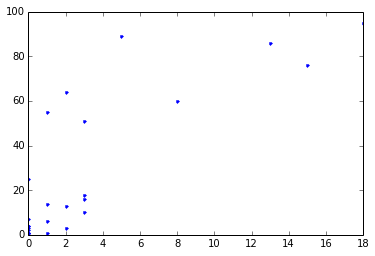

In [28]:
fig = plt.figure()
plt.plot(gdf['2006'].values,gdf['2007'].values,'b.')

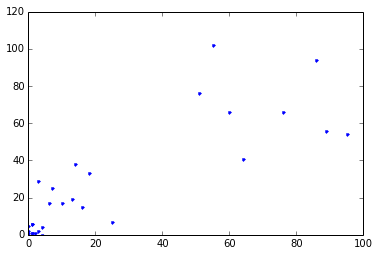

In [29]:
fig = plt.figure()
plt.plot(gdf['2007'].values,gdf['2008'].values,'b.')

Los datos no parecen estar demasiado correlacionados, pero, para estar seguros, calculemos su matriz de correlación:

In [30]:
gdf.corr()

,2006,2007,2008,2009,2010,2011,2012,2013,2014,poblacion
2006,1.000000,0.823253,0.639757,0.794676,0.602856,0.653335,0.652128,0.659937,0.672839,0.580163
2007,0.823253,1.000000,0.851089,0.840444,0.580944,0.607433,0.554295,0.624447,0.611611,0.481846
2008,0.639757,0.851089,1.000000,0.821370,0.574631,0.563220,0.528423,0.675380,0.558386,0.290222
2009,0.794676,0.840444,0.821370,1.000000,0.826673,0.857999,0.828250,0.819015,0.726112,0.431652
2010,0.602856,0.580944,0.574631,0.826673,1.000000,0.976591,0.947560,0.778131,0.689586,0.094240
2011,0.653335,0.607433,0.563220,0.857999,0.976591,1.000000,0.974992,0.832292,0.738565,0.206983
2012,0.652128,0.554295,0.528423,0.828250,0.947560,0.974992,1.000000,0.886192,0.823540,0.207003
2013,0.659937,0.624447,0.675380,0.819015,0.778131,0.832292,0.886192,1.000000,0.854907,0.367245
2014,0.672839,0.611611,0.558386,0.726112,0.689586,0.738565,0.823540,0.854907,1.000000,0.443001
poblacion,0.580163,0.481846,0.290222,0.431652,0.094240,0.206983,0.207003,0.367245,0.443001,1.000000


Como podemos ver, en realidad los datos sí están bastante correlacionados, aunque para cada año sólo tenemos 32 observaciones, piensen qué quiere decir esto en términos de la significancia.

Por lo pronto, vamos a seleccionar como candidatos todos los años que tengan un valor de correlación menor a 0.7

In [31]:
corr = gdf.corr()
corr[corr<0.7]

,2006,2007,2008,2009,2010,2011,2012,2013,2014,poblacion
2006,NaN,NaN,0.639757,NaN,0.602856,0.653335,0.652128,0.659937,0.672839,0.580163
2007,NaN,NaN,NaN,NaN,0.580944,0.607433,0.554295,0.624447,0.611611,0.481846
2008,0.639757,NaN,NaN,NaN,0.574631,0.563220,0.528423,0.675380,0.558386,0.290222
2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.431652
2010,0.602856,0.580944,0.574631,NaN,NaN,NaN,NaN,NaN,0.689586,0.094240
2011,0.653335,0.607433,0.563220,NaN,NaN,NaN,NaN,NaN,NaN,0.206983
2012,0.652128,0.554295,0.528423,NaN,NaN,NaN,NaN,NaN,NaN,0.207003
2013,0.659937,0.624447,0.675380,NaN,NaN,NaN,NaN,NaN,NaN,0.367245
2014,0.672839,0.611611,0.558386,NaN,0.689586,NaN,NaN,NaN,NaN,0.443001
poblacion,0.580163,0.481846,0.290222,0.431652,0.094240,0.206983,0.207003,0.367245,0.443001,NaN


Como pueden ver, el único año que se elimina por completo es el 2009, entonces usemos todos los demás años:

In [32]:
variables = gdf[['2006','2007','2008','2010','2011','2012','2013','2014','geometry','nombre','CVEGEO']]
variables.head()

,2006,2007,2008,2010,2011,2012,2013,2014,geometry,nombre,CVEGEO
0,0,25,7,18,30,14,15,62,"POLYGON ((-102.287865181776 22.41649003941674,...",Aguascalientes,01
1,0,7,25,8,19,128,177,381,(POLYGON ((-112.663839812965 28.41882990629272...,Baja California,02
2,0,0,2,3,2,3,8,3,(POLYGON ((-109.8946081395473 22.8748229076171...,Baja California Sur,03
3,0,0,5,1,0,0,10,59,"(POLYGON ((-90.379356996781 20.84832728852915,...",Campeche,04
4,1,55,102,227,258,136,233,103,POLYGON ((-102.3107926469074 29.87694857356026...,Coahuila de Zaragoza,05


Lo que hicimos aquí fue definir un Nuevo GeoDataFrame, sólo con las variables que nos interesan. Ahora, como recordarán, la librería que usamos para regionalizar (`clusterpy`) necesita _shapefiles_, afortunadamente, GeoPandas nos da una forma muy facil de exportar archivos:

In [33]:
variables.to_file('datos/variables.shp')

Ahora tenemos un _shapefile_ con as variables que queremos, hagamos una regionalización:

In [34]:
desaparecidos = clusterpy.importArcData("datos/variables")
desaparecidos.cluster('arisel', ['2006','2007','2008','2010','2011','2012','2013','2014']
                      , 6, wType='rook', inits=10, dissolve=0)
desaparecidos.exportArcData('datos/regiones_desaparecidos')

Loading datos/variables.dbf
Loading datos/variables.shp
Done
Getting variables
Variables successfully extracted
Running original Arisel algorithm
Number of areas:  32
Number of regions:  6
initial Solution:  [0, 2, 2, 3, 2, 4, 3, 2, 3, 0, 4, 3, 0, 5, 4, 4, 3, 0, 2, 3, 4, 0, 3, 0, 2, 2, 3, 1, 0, 3, 3, 0]
initial O.F:  723932.0
FINAL SOLUTION:  [0, 2, 2, 3, 2, 4, 3, 2, 3, 0, 4, 3, 0, 5, 4, 4, 3, 0, 2, 3, 4, 0, 3, 0, 2, 2, 3, 1, 0, 4, 3, 0]
FINAL OF:  716304.0
Done
Adding variables
Done
Writing ESRI files
Writing DBF file
Done
ESRI files created


Ahora ya tenemos una primera regionalización, pero, ¿no será mejor trabajar con tasas de desaparecidos en lugar de con cantidades?

Las cantidades son importantes, pero pueden estar sesgadas por el número de habitantes, repitamos el ejercicio ahora con tasas.

Aqui podemos hacer las operaciones necesarias, pero va a ser más fácil para ustedes hacerlas en Qgis.

Una vez que tengan su nuevo shape con las tasas de desaparecidos, repitan el proceso para hacer una regionalización. 